# EDA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = 'tripdata_ACSData_2023-09.csv'
df = pd.read_csv(file_path)

In [3]:
print(" Dataset shape (rows, columns):", df.shape)

print("\n Columns:")
print(df.columns.tolist())

print("\n Data types:")
print(df.dtypes)

print("\n Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False))

 Dataset shape (rows, columns): (19958941, 45)

 Columns:
['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num', 'request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay', 'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag', 'pickup_zipcode', 'dropoff_zipcode', 'zipcode', 'Households!!Total', 'Households!!Median income (dollars)', 'Households!!Mean income (dollars)', 'Families!!Total', 'Total!!Population for whom poverty status is determined', 'Total!!Population for whom poverty status is determined!!SEX!!Male', 'Total!!Population for whom poverty status is determined!!SEX!!Female', 'Below poverty level!!Population for whom poverty status is determined', 'Percent below poverty level!!Population for whom poverty status is determined

In [ ]:
print(df.iloc[0].to_string())

hvfhs_license_num                                                                             HV0003
dispatching_base_num                                                                          B03404
originating_base_num                                                                          B03404
request_datetime                                                                 2023-09-01 00:00:13
on_scene_datetime                                                                2023-09-01 00:02:47
pickup_datetime                                                                  2023-09-01 00:02:56
dropoff_datetime                                                                 2023-09-01 00:14:08
PULocationID                                                                                       7
DOLocationID                                                                                     226
trip_miles                                                                                 

In [5]:
df_clean = df.dropna(subset=['pickup_zipcode', 'dropoff_zipcode', 'zipcode'])
print(f"Rows after dropping null zipcodes: {len(df_clean):,}")
initial_rows = len(df)
dropped_rows = initial_rows - len(df_clean)
print(f"Dropped rows with missing zipcodes: {dropped_rows:,}")

Rows after dropping null zipcodes: 18,706,339
Dropped rows with missing zipcodes: 1,252,602


In [6]:
negative_fares = df_clean[df_clean['base_passenger_fare'] < 0]
print(f"Number of trips with negative base fare: {len(negative_fares):,}")

Number of trips with negative base fare: 605


In [7]:
# remove the negative base fare rows
df_clean = df_clean[df_clean['base_passenger_fare'] >= 0]
print(f"Rows after dropping negative base fare: {len(df_clean):,}")

Rows after dropping negative base fare: 18,705,734


In [8]:
df_clean.to_feather("df_clean.feather")

# Company-Level Overview

In [9]:
print("Unique HVFHS license numbers in cleaned data:")
print(df_clean['hvfhs_license_num'].unique())

Unique HVFHS license numbers in cleaned data:
['HV0003' 'HV0005']


In [10]:
# Map license numbers to company names
company_map = {
    'HV0002': 'Juno',
    'HV0003': 'Uber',
    'HV0004': 'Via',
    'HV0005': 'Lyft'
}
df_clean.loc[:, 'company'] = df_clean['hvfhs_license_num'].map(company_map)

# Group by company
company_summary = df_clean.groupby('company').agg(
    num_trips=('hvfhs_license_num', 'count'),
    total_fare=('base_passenger_fare', 'sum'),
    avg_fare=('base_passenger_fare', 'mean')
).reset_index()

# Add percentage of total trips
total_trips = company_summary['num_trips'].sum()
company_summary['trip_share_%'] = round(company_summary['num_trips'] / total_trips * 100, 2)

# Display summary
print("Company-Level Summary:")
print(company_summary)

Company-Level Summary:
  company  num_trips    total_fare   avg_fare  trip_share_%
0    Lyft    5229745  1.137932e+08  21.758840         27.96
1    Uber   13475989  3.297481e+08  24.469303         72.04


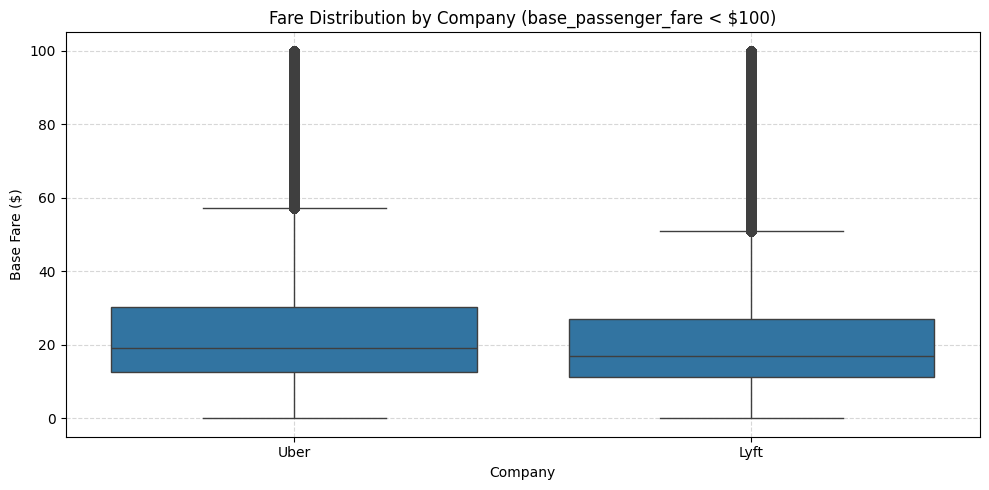

In [11]:
# Boxplot: Fare distribution by company
plt.figure(figsize=(10, 5))
sns.boxplot(x='company', y='base_passenger_fare', data=df_clean[df_clean['base_passenger_fare'] < 100])  # remove extreme outliers
plt.title("Fare Distribution by Company (base_passenger_fare < $100)")
plt.ylabel("Base Fare ($)")
plt.xlabel("Company")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Ride-Type Breakdown

```
shared_request_flag: Did the passenger agree to a shared/pooled ride, regardless of whether they were matched? (Y/N) 
shared_match_flag: Did the passenger share the vehicle with another passenger who booked separately at any point during the trip? (Y/N)
wav_request_flag: Did the passenger request a wheelchair-accessible vehicle (WAV)? (Y/N) 
wav_match_flag: Did the trip occur in a wheelchair-accessible vehicle (WAV)? (Y/N)
```

In [12]:
# Set float display format
pd.options.display.float_format = '{:,.2f}'.format

# Shared ride request flag summary
shared_summary = df_clean['shared_request_flag'].value_counts(dropna=False).rename_axis('shared_request_flag').reset_index(name='count')
shared_summary['percentage'] = (shared_summary['count'] / len(df_clean) * 100).round(2)
print("Shared Request Flag Summary:")
print(shared_summary)

# Shared ride match flag summary
match_summary = df_clean['shared_match_flag'].value_counts(dropna=False).rename_axis('shared_match_flag').reset_index(name='count')
match_summary['percentage'] = (match_summary['count'] / len(df_clean) * 100).round(2)
print("\nShared Match Flag Summary:")
print(match_summary)

# Average fare by shared request status
print("\nAverage Base Fare by Shared Request Flag:")
print(df_clean.groupby('shared_request_flag')['base_passenger_fare'].mean())

Shared Request Flag Summary:
  shared_request_flag     count  percentage
0                   N  18140357       96.98
1                   Y    565377        3.02

Shared Match Flag Summary:
  shared_match_flag     count  percentage
0                 N  18527040       99.04
1                 Y    178694        0.96

Average Base Fare by Shared Request Flag:
shared_request_flag
N   23.85
Y   19.37
Name: base_passenger_fare, dtype: float64


In [13]:
# WAV request flag summary
wav_request_summary = df_clean['wav_request_flag'].value_counts(dropna=False).rename_axis('wav_request_flag').reset_index(name='count')
wav_request_summary['percentage'] = (wav_request_summary['count'] / len(df_clean) * 100).round(2)
print("\nWAV Request Flag Summary:")
print(wav_request_summary)

# WAV match flag summary
wav_match_summary = df_clean['wav_match_flag'].value_counts(dropna=False).rename_axis('wav_match_flag').reset_index(name='count')
wav_match_summary['percentage'] = (wav_match_summary['count'] / len(df_clean) * 100).round(2)
print("\nWAV Match Flag Summary:")
print(wav_match_summary)


WAV Request Flag Summary:
  wav_request_flag     count  percentage
0                N  18666657       99.79
1                Y     39077        0.21

WAV Match Flag Summary:
  wav_match_flag     count  percentage
0              N  17004856       90.91
1              Y   1700878        9.09


In [ ]:
# Categorize ride type for comparison
def label_ride_type(row):
    if row['access_a_ride_flag'] == 'Y':
        return 'Accessible'
    elif row['shared_request_flag'] == 'Y':
        return 'Shared'
    else:
        return 'Regular'

df_clean['ride_type'] = df_clean.apply(label_ride_type, axis=1)

# Calculate average toll per ride type
toll_comparison = df_clean.groupby('ride_type')['tolls'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(toll_comparison['ride_type'], toll_comparison['tolls'], color=['#3182bd', '#9ecae1', '#fdae6b'])
plt.title("Average Tolls by Ride Type")
plt.xlabel("Ride Type")
plt.ylabel("Average Toll ($)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Geographic Patterns

In [ ]:
Median fare, min/max fare, avg fare by dropoff_zipcode

Trip count heatmap by zipcode

Distance vs. fare across different areas

Are certain zip codes always paying more per mile?

In [4]:
print("Number of unique dropoff zipcodes:", df_clean['dropoff_zipcode'].nunique())
print("Number of unique pickup zipcodes:", df_clean['pickup_zipcode'].nunique())

Number of unique dropoff zipcodes: 156
Number of unique pickup zipcodes: 159


In [ ]:
# Group by dropoff_zipcode
df_clean = pd.read_feather("df_clean.feather")


# Basic zipcode-level aggregation
zipcode_stats = df_clean.groupby('dropoff_zipcode').agg(
    trip_count=('base_passenger_fare', 'count'),
    median_fare=('base_passenger_fare', 'median'),
    avg_fare=('base_passenger_fare', 'mean'),
    std_fare=('base_passenger_fare', 'std'),
    min_fare=('base_passenger_fare', 'min'),
    max_fare=('base_passenger_fare', 'max'),
    avg_miles=('trip_miles', 'mean'),
    avg_fare_per_mile=('base_passenger_fare', lambda x: x.sum() / df_clean.loc[x.index, 'trip_miles'].sum())
).reset_index()

# Coefficient of variation (std / mean)
zipcode_stats['fare_cv'] = zipcode_stats['std_fare'] / zipcode_stats['avg_fare']

# Interquartile range (IQR)
q1 = df_clean.groupby('dropoff_zipcode')['base_passenger_fare'].quantile(0.25)
q3 = df_clean.groupby('dropoff_zipcode')['base_passenger_fare'].quantile(0.75)
iqr = (q3 - q1).rename('fare_iqr')
zipcode_stats = zipcode_stats.merge(iqr, on='dropoff_zipcode', how='left')

# Count of expensive trips (> $100) Flags unusual high-fare density
expensive_counts = df_clean[df_clean['base_passenger_fare'] > 100].groupby('dropoff_zipcode').size()
zipcode_stats['num_expensive'] = zipcode_stats['dropoff_zipcode'].map(expensive_counts).fillna(0).astype(int)

# % of short trips (< 1 mile) Helps detect if short rides are overcharged in some areas
short_counts = df_clean[df_clean['trip_miles'] < 1].groupby('dropoff_zipcode').size()
zipcode_stats['pct_short_trips'] = (short_counts / zipcode_stats['trip_count']).fillna(0) * 100
# View top rows
print(zipcode_stats.head())

   dropoff_zipcode  trip_count  median_fare   avg_fare   std_fare  min_fare  \
0          10001.0      644546        22.51  25.995355  15.902184      0.14   
1          10002.0      266096        21.44  24.559954  15.096181      1.54   
2          10003.0      350526        19.79  22.865550  14.196604      0.93   
3          10004.0       56420        27.25  31.021865  17.883507      2.23   
4          10005.0      124816        25.19  29.274113  17.982477      1.74   

   max_fare  avg_miles  avg_fare_per_mile   fare_cv  fare_iqr  num_expensive  \
0   1133.44   3.628515           7.164186  0.611732     17.51           2387   
1   1076.33   3.962520           6.198064  0.614667     15.01            855   
2    630.00   3.303700           6.921194  0.620873     14.79            828   
3    306.75   5.574963           5.564497  0.576481     19.73            346   
4    337.17   5.284499           5.539619  0.614279     18.86            772   

   pct_short_trips  
0              0.0  
1 

In [10]:
# Top 10 by average fare
top10_avg = zipcode_stats.sort_values('avg_fare', ascending=False).head(10)
print("Top 10 Zipcodes by Average Fare:")
print(top10_avg[['dropoff_zipcode', 'avg_fare', 'trip_count']])
print("\n" + "="*60 + "\n")

# Bottom 10 by average fare
bottom10_avg = zipcode_stats.sort_values('avg_fare', ascending=True).head(10)
print("Bottom 10 Zipcodes by Average Fare:")
print(bottom10_avg[['dropoff_zipcode', 'avg_fare', 'trip_count']])
print("\n" + "="*60 + "\n")

# Top 10 by fare per mile
top10_ppm = zipcode_stats.sort_values('avg_fare_per_mile', ascending=False).head(10)
print("Top 10 Zipcodes by Average Fare per Mile:")
print(top10_ppm[['dropoff_zipcode', 'avg_fare_per_mile', 'avg_miles', 'trip_count']])
print("\n" + "="*60 + "\n")

# Top 10 most variable fares (by std deviation)
top10_variable = zipcode_stats.sort_values('std_fare', ascending=False).head(10)
print("Top 10 Zipcodes by Fare Variability (Std Dev):")
print(top10_variable[['dropoff_zipcode', 'std_fare', 'avg_fare', 'trip_count']])

Top 10 Zipcodes by Average Fare:
     dropoff_zipcode   avg_fare  trip_count
147          11430.0  54.316882      459762
126          11371.0  46.811489      417610
30           10036.0  31.644895      226208
155          11697.0  31.361698        5011
5            10006.0  31.084131       79210
3            10004.0  31.021865       56420
4            10005.0  29.274113      124816
14           10018.0  29.168880       99830
36           10111.0  29.163099      225192
61           10464.0  28.710810        4200


Bottom 10 Zipcodes by Average Fare:
     dropoff_zipcode   avg_fare  trip_count
57           10460.0  17.297348      111137
40           10303.0  17.318387       20949
68           10472.0  17.320361       85370
50           10453.0  17.324577       72174
66           10469.0  17.526558       38203
52           10455.0  17.548320       82556
53           10456.0  17.549934       62298
54           10457.0  17.656418      228530
69           10473.0  17.687414       82943
127  

C:\Users\Dell\AppData\Local\Temp\ipykernel_18956\1964192758.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


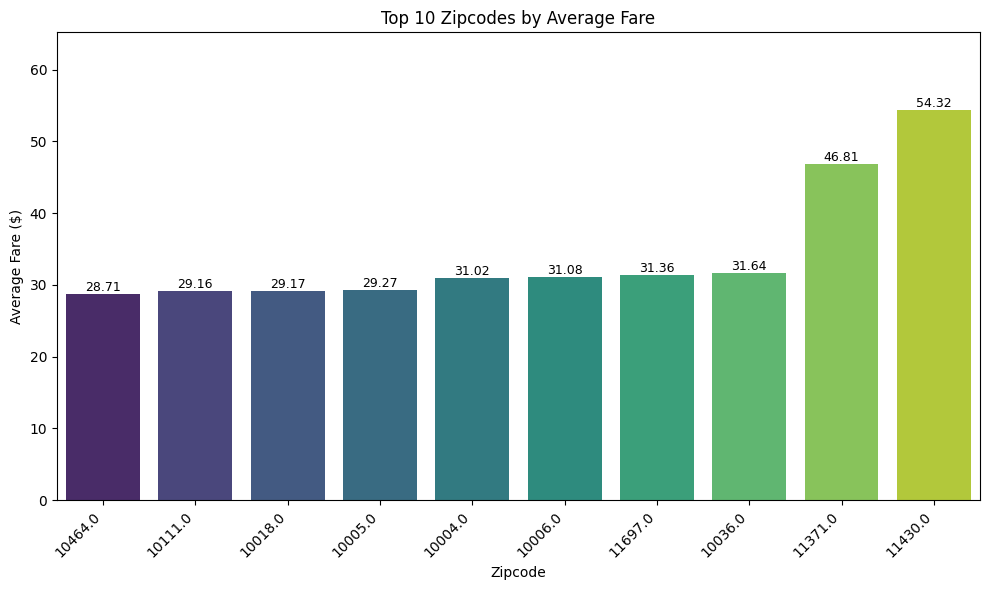

C:\Users\Dell\AppData\Local\Temp\ipykernel_18956\1964192758.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


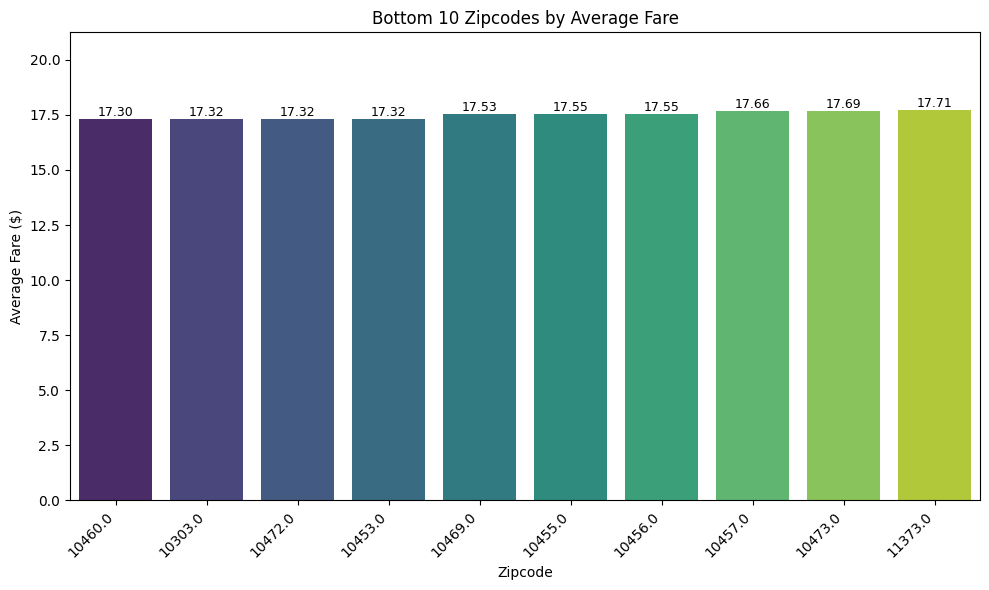

C:\Users\Dell\AppData\Local\Temp\ipykernel_18956\1964192758.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


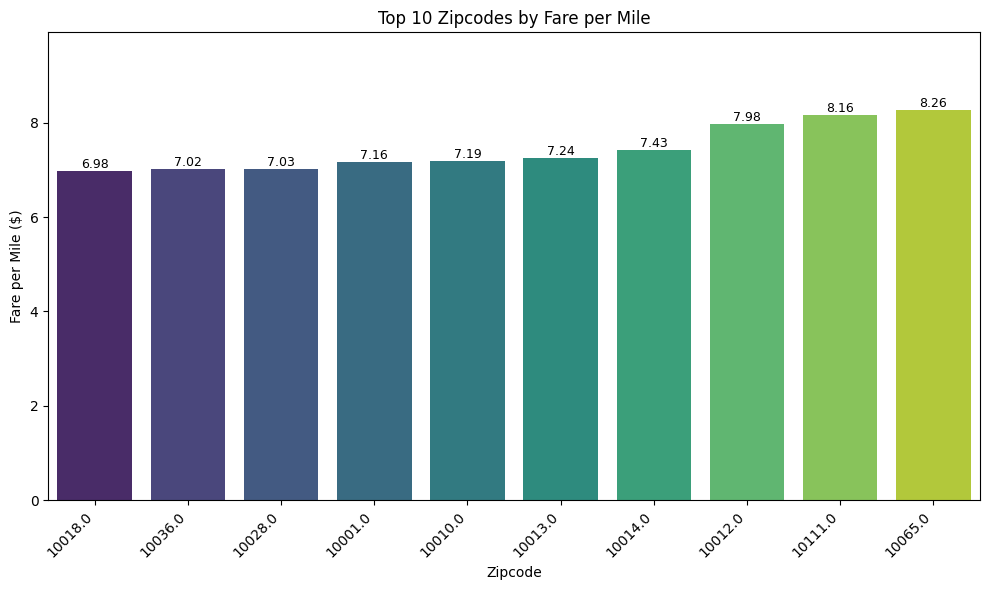

C:\Users\Dell\AppData\Local\Temp\ipykernel_18956\1964192758.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


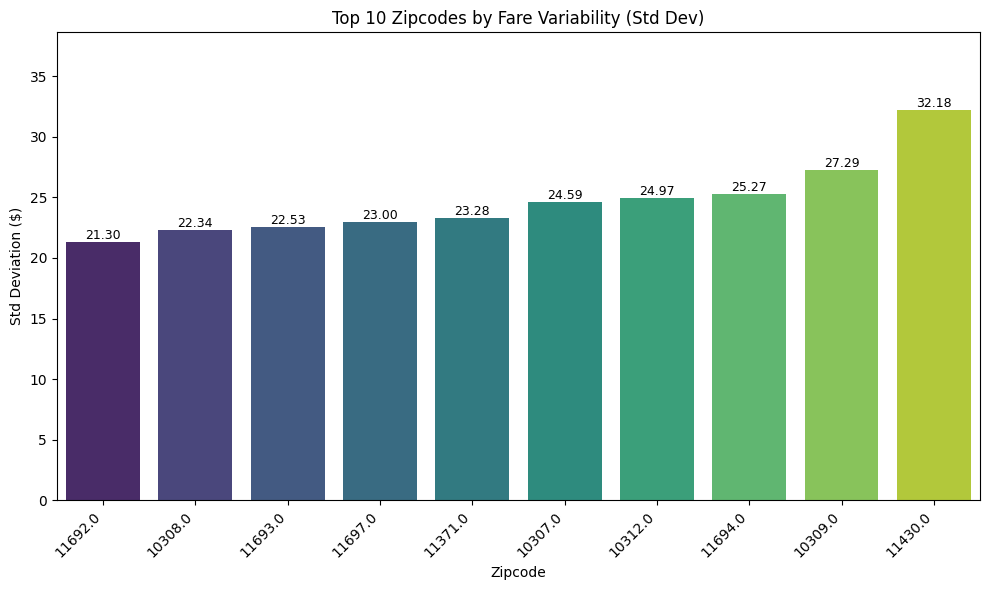

In [27]:
def annotated_barplot(data, x, y, title, ylabel):
    # Sort by y to control bar order (left to right)
    data_sorted = data.sort_values(by=y, ascending=True)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=data_sorted,
        x=x,
        y=y,
        palette='viridis',
        order=data_sorted[x]  # ensure left-to-right ordering
    )
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Zipcode")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, data_sorted[y].max() * 1.2)

    # Add real value labels on top
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# Create all 4 annotated plots
annotated_barplot(top10_avg, 'dropoff_zipcode', 'avg_fare', "Top 10 Zipcodes by Average Fare", "Average Fare ($)")
annotated_barplot(bottom10_avg, 'dropoff_zipcode', 'avg_fare', "Bottom 10 Zipcodes by Average Fare", "Average Fare ($)")
annotated_barplot(top10_ppm, 'dropoff_zipcode', 'avg_fare_per_mile', "Top 10 Zipcodes by Fare per Mile", "Fare per Mile ($)")
annotated_barplot(top10_variable, 'dropoff_zipcode', 'std_fare', "Top 10 Zipcodes by Fare Variability (Std Dev)", "Std Deviation ($)")

C:\Users\Dell\AppData\Local\Temp\ipykernel_18956\3280311993.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_zipcodes, x='dropoff_zipcode', y='trip_count', palette='Blues_d')


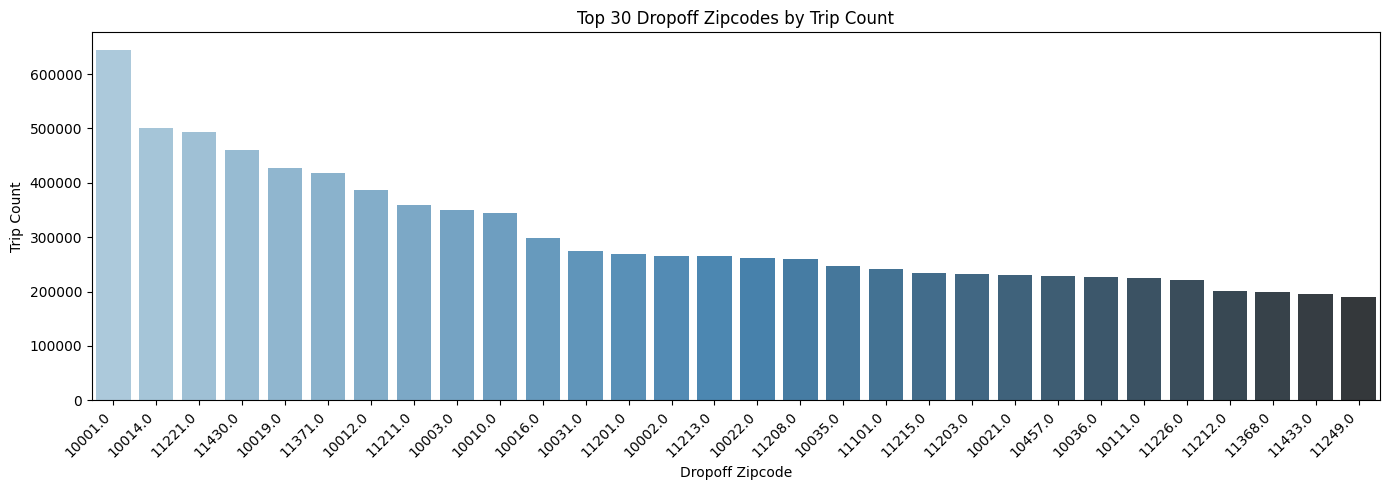

In [12]:
# Heatmap of trip counts by zipcode
top_zipcodes['dropoff_zipcode'] = top_zipcodes['dropoff_zipcode'].astype(str)
plt.figure(figsize=(14, 5))
sns.barplot(data=top_zipcodes, x='dropoff_zipcode', y='trip_count', palette='Blues_d')
plt.title("Top 30 Dropoff Zipcodes by Trip Count")
plt.xlabel("Dropoff Zipcode")
plt.ylabel("Trip Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

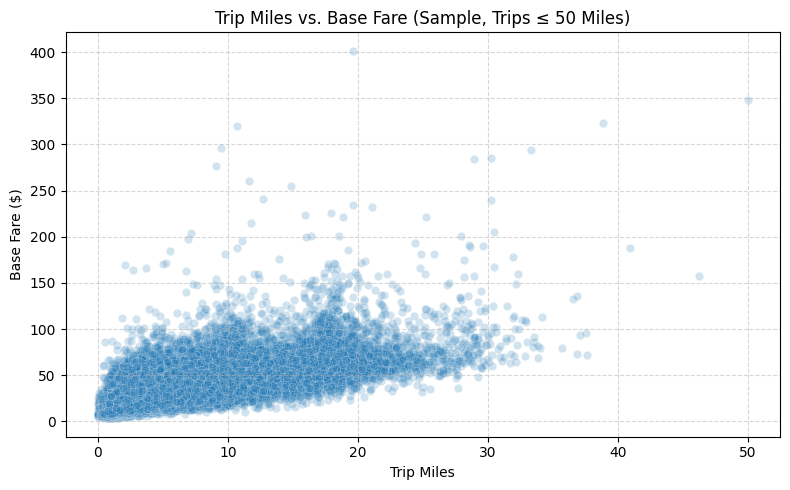

In [14]:
plt.figure(figsize=(8, 5))

# Filter data: only keep trips with miles between 0 and 50 and positive fare
sample = df_clean[
    (df_clean['trip_miles'] > 0) &
    (df_clean['trip_miles'] <= 50) &
    (df_clean['base_passenger_fare'] > 0)
].sample(100000, random_state=1)

# Plot
sns.scatterplot(data=sample, x='trip_miles', y='base_passenger_fare', alpha=0.2)
plt.title("Trip Miles vs. Base Fare (Sample, Trips ≤ 50 Miles)")
plt.xlabel("Trip Miles")
plt.ylabel("Base Fare ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

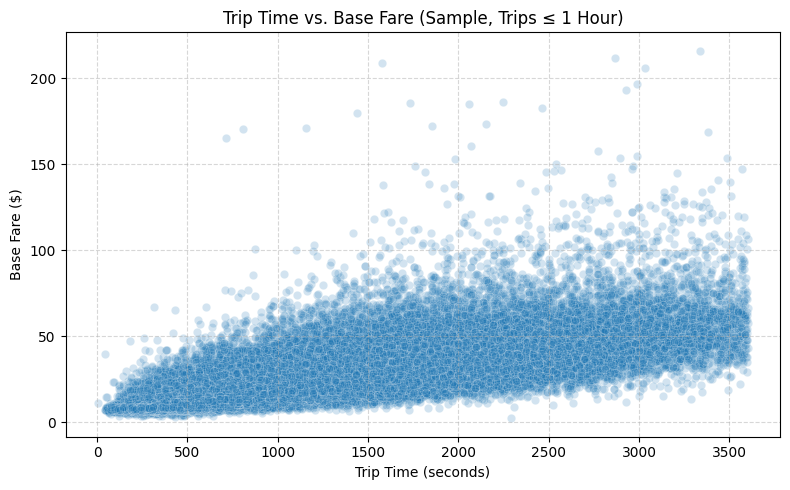

In [15]:
plt.figure(figsize=(8, 5))

# Filter: trip_time > 0 and ≤ 3600 seconds (1 hour), positive fare
sample = df_clean[
    (df_clean['trip_time'] > 0) &
    (df_clean['trip_time'] <= 3600) &
    (df_clean['base_passenger_fare'] > 0)
].sample(100000, random_state=1)

# Plot
sns.scatterplot(data=sample, x='trip_time', y='base_passenger_fare', alpha=0.2)
plt.title("Trip Time vs. Base Fare (Sample, Trips ≤ 1 Hour)")
plt.xlabel("Trip Time (seconds)")
plt.ylabel("Base Fare ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Demographics & Bias Indicators

In [77]:
# Read the full cleaned dataset
df_clean = pd.read_feather("df_clean.feather")

# Select only relevant demographic and fare columns
columns_needed = [
    'dropoff_zipcode',
    'Households!!Median income (dollars)',
    'Percent below poverty level!!Population for whom poverty status is determined',
    'RACE!!Total population!!One race!!White',
    'RACE!!Total population!!One race!!Black or African American',
    'RACE!!Total population!!One race!!Asian',
    'RACE!!Total population!!One race!!Some Other Race',
    'Total population',
    'base_passenger_fare',
    'tolls'
]

df_demo = df_clean[columns_needed].copy()

# Convert critical columns to numeric safely
numeric_cols = [
    'Households!!Median income (dollars)',
    'Percent below poverty level!!Population for whom poverty status is determined',
    'Total population'
]

for col in numeric_cols:
    df_demo[col] = pd.to_numeric(df_demo[col], errors='coerce')

# Drop rows with any missing key demographic values
df_demo.dropna(subset=numeric_cols, inplace=True)

# Save cleaned subset
df_demo.to_feather("df_demo.feather")


In [65]:
# Read cleaned feather
df_demo = pd.read_feather("df_demo.feather")

# Group by zipcode and aggregate demographics
demographic_summary = df_demo.groupby('dropoff_zipcode').agg(
    median_income=('Households!!Median income (dollars)', 'mean'),
    poverty_rate=('Percent below poverty level!!Population for whom poverty status is determined', 'mean'),
    avg_fare=('base_passenger_fare', 'mean'),
    white=('RACE!!Total population!!One race!!White', 'sum'),
    black=('RACE!!Total population!!One race!!Black or African American', 'sum'),
    asian=('RACE!!Total population!!One race!!Asian', 'sum'),
    other=('RACE!!Total population!!One race!!Some Other Race', 'sum'),
    total_population=('Total population', 'sum')
).reset_index()

# Compute racial percentages properly
demographic_summary['white_pct'] = demographic_summary['white'] / demographic_summary['total_population']
demographic_summary['black_pct'] = demographic_summary['black'] / demographic_summary['total_population']
demographic_summary['asian_pct'] = demographic_summary['asian'] / demographic_summary['total_population']
demographic_summary['other_pct'] = demographic_summary['other'] / demographic_summary['total_population']

# Bin zipcodes into income deciles
demographic_summary['income_decile'] = pd.qcut(demographic_summary['median_income'], 10, labels=False)
income_bins = pd.qcut(demographic_summary['median_income'], 10)
demographic_summary['income_decile_label'] = income_bins

# Compare avg fare by income decile
income_decile_fares = demographic_summary.groupby('income_decile')['avg_fare'].mean().reset_index()


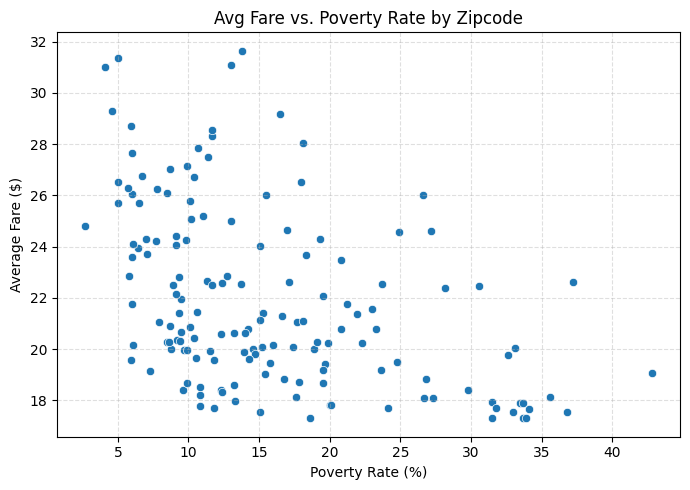

In [66]:
# Scatter: Poverty Rate vs. Avg Fare
plt.figure(figsize=(7, 5))
sns.scatterplot(data=demographic_summary, x='poverty_rate', y='avg_fare')
plt.title("Avg Fare vs. Poverty Rate by Zipcode")
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Average Fare ($)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

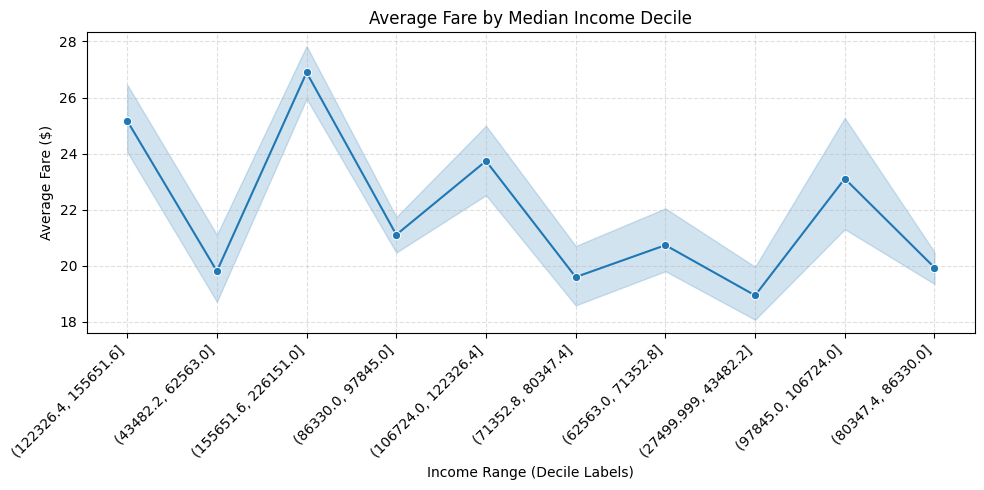

In [67]:
# Line Plot: Income Decile vs. Avg Fare
demographic_summary['income_decile_label'] = demographic_summary['income_decile_label'].astype(str)

plt.figure(figsize=(10, 5))
sns.lineplot(data=demographic_summary, x='income_decile_label', y='avg_fare', marker='o')
plt.title("Average Fare by Median Income Decile")
plt.xlabel("Income Range (Decile Labels)")
plt.ylabel("Average Fare ($)")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_18956\339978776.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_top, x='Race', y='Proportion', palette='pastel')


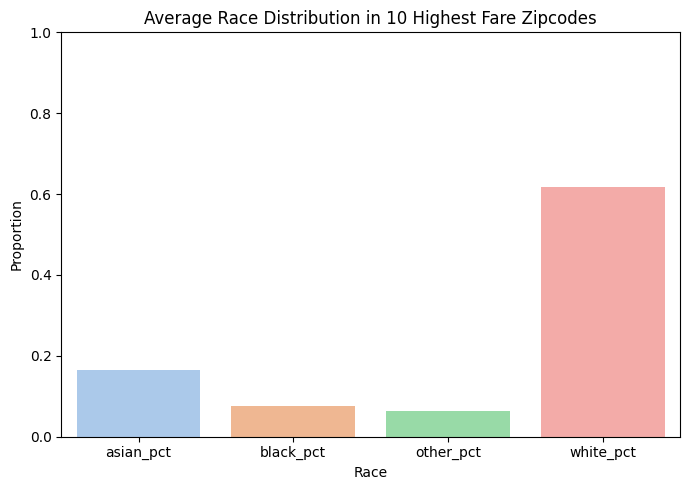

C:\Users\Dell\AppData\Local\Temp\ipykernel_18956\339978776.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_bottom, x='Race', y='Proportion', palette='muted')


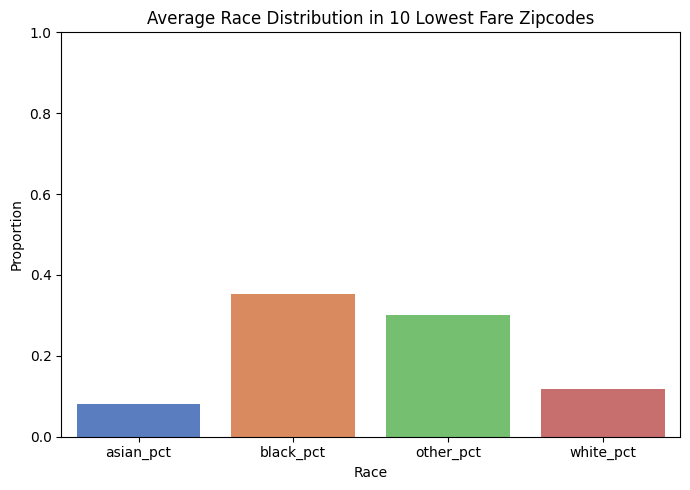

In [ ]:
# Top 10 by fare
top_zip = demographic_summary.sort_values('avg_fare', ascending=False).head(10)

# Bottom 10 by fare
bottom_zips = demographic_summary.sort_values('avg_fare', ascending=True).head(10)

# Melt for grouped barplot
top_melted = top_zip.melt(id_vars='dropoff_zipcode', value_vars=['white_pct', 'black_pct', 'asian_pct', 'other_pct'],
                          var_name='Race', value_name='Proportion')
bottom_melted = bottom_zips.melt(id_vars='dropoff_zipcode', value_vars=['white_pct', 'black_pct', 'asian_pct', 'other_pct'],
                                 var_name='Race', value_name='Proportion')

# Barplot for top 10 (avg across them)
avg_top = top_melted.groupby('Race')['Proportion'].mean().reset_index()
plt.figure(figsize=(7, 5))
sns.barplot(data=avg_top, x='Race', y='Proportion', palette='pastel')
plt.title("Average Race Distribution in 10 Highest Fare Zipcodes")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Barplot for bottom 10 (avg across them)
avg_bottom = bottom_melted.groupby('Race')['Proportion'].mean().reset_index()
plt.figure(figsize=(7, 5))
sns.barplot(data=avg_bottom, x='Race', y='Proportion', palette='muted')
plt.title("Average Race Distribution in 10 Lowest Fare Zipcodes")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

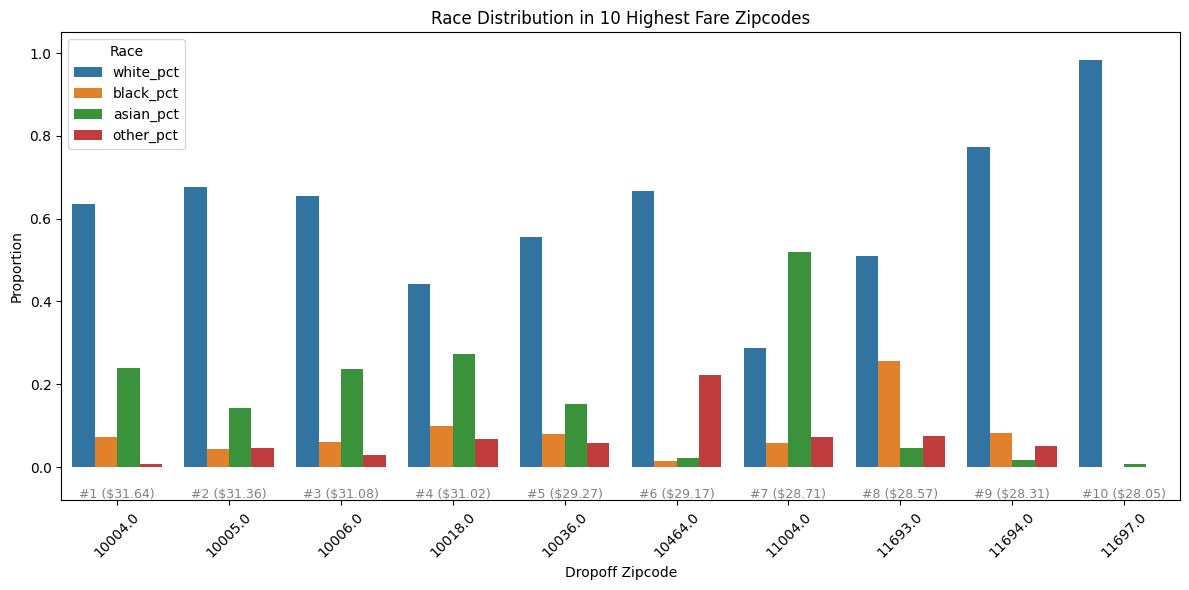

In [74]:
# Prepare top 10 by fare
top_zip = demographic_summary.sort_values('avg_fare', ascending=False).head(10).copy()
top_zip['Rank'] = range(1, 11)
top_melted = top_zip.melt(
    id_vars=['dropoff_zipcode', 'Rank', 'avg_fare'],
    value_vars=['white_pct', 'black_pct', 'asian_pct', 'other_pct'],
    var_name='Race',
    value_name='Proportion'
)

# Plot: Grouped bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_melted, x='dropoff_zipcode', y='Proportion', hue='Race')
plt.title("Race Distribution in 10 Highest Fare Zipcodes")
plt.ylim(-0.08, 1.05)
plt.xlabel("Dropoff Zipcode")
plt.ylabel("Proportion")
plt.xticks(rotation=45)

# Add rank + avg fare annotation BELOW each group
for i, (zipcode, rank, fare) in enumerate(zip(top_zip['dropoff_zipcode'], top_zip['Rank'], top_zip['avg_fare'])):
    plt.text(i, -0.05, f"#{rank} (${fare:.2f})", ha='center', va='top', fontsize=9, color='gray')

plt.tight_layout()
plt.show()


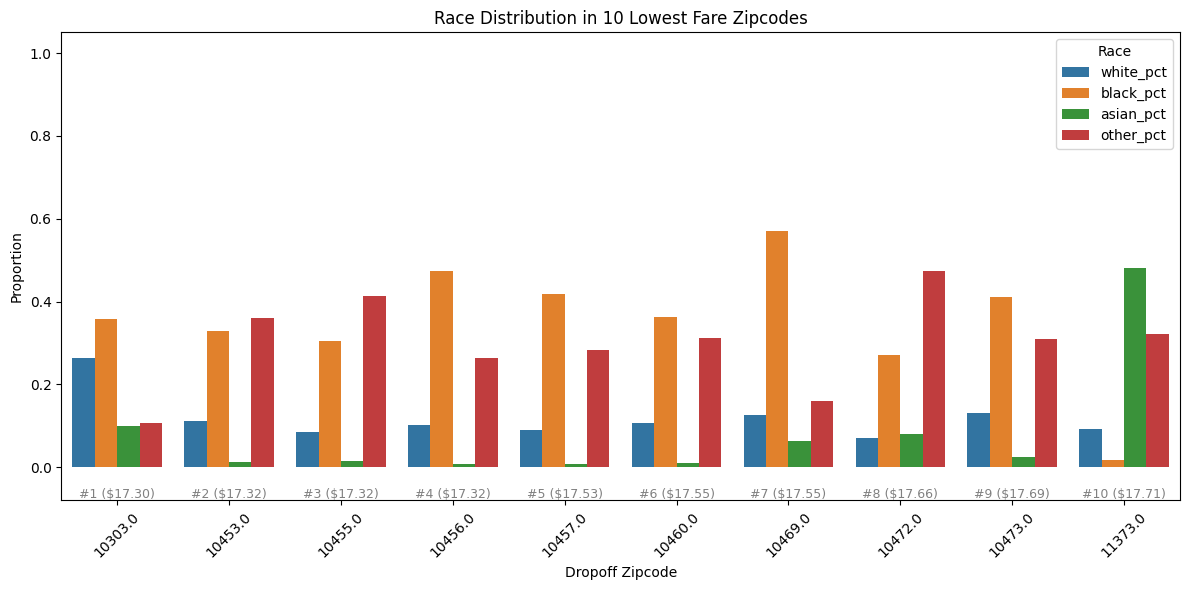

In [73]:
# Prepare bottom 10 by fare
bottom_zip = demographic_summary.sort_values('avg_fare', ascending=True).head(10).copy()
bottom_zip['Rank'] = range(1, 11)
bottom_melted = bottom_zip.melt(
    id_vars=['dropoff_zipcode', 'Rank', 'avg_fare'],
    value_vars=['white_pct', 'black_pct', 'asian_pct', 'other_pct'],
    var_name='Race',
    value_name='Proportion'
)

# Plot: Grouped bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=bottom_melted, x='dropoff_zipcode', y='Proportion', hue='Race')
plt.title("Race Distribution in 10 Lowest Fare Zipcodes")
plt.ylim(-0.08, 1.05)
plt.xlabel("Dropoff Zipcode")
plt.ylabel("Proportion")
plt.xticks(rotation=45)

# Add rank + avg fare annotation BELOW each group
x_labels = [tick.get_text() for tick in ax.get_xticklabels()]
for i, (zipcode, rank, fare) in enumerate(zip(bottom_zip['dropoff_zipcode'], bottom_zip['Rank'], bottom_zip['avg_fare'])):
    plt.text(i, -0.05, f"#{rank} (${fare:.2f})", ha='center', va='top', fontsize=9, color='gray')

plt.tight_layout()
plt.show()


In [93]:
# Load the cleaned demographic dataset
df_demo = pd.read_feather("df_demo.feather")

# Bin percent poverty into 5 levels
df_demo['poverty_bin'] = pd.qcut(
    df_demo['Percent below poverty level!!Population for whom poverty status is determined'],
    q=5,
    labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']
)

# Bin white_pct into 5 levels
df_demo['white_pct'] = df_demo['RACE!!Total population!!One race!!White'] / df_demo['Total population']
df_demo['white_bin'] = pd.qcut(df_demo['white_pct'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

# Bin black_pct into 5 levels
df_demo['black_pct'] = df_demo['RACE!!Total population!!One race!!Black or African American'] / df_demo['Total population']
df_demo['black_bin'] = pd.qcut(df_demo['black_pct'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

# Bin Asian population share
df_demo['asian_pct'] = df_demo['RACE!!Total population!!One race!!Asian'] / df_demo['Total population']
df_demo['asian_bin'] = pd.qcut(df_demo['asian_pct'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

# Bin Other race population share
df_demo['other_pct'] = df_demo['RACE!!Total population!!One race!!Some Other Race'] / df_demo['Total population']
df_demo['other_bin'] = pd.qcut(df_demo['other_pct'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])


C:\Users\Dell\AppData\Local\Temp\ipykernel_18956\3859376675.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  poverty_summary = df_demo.groupby('poverty_bin').agg(
C:\Users\Dell\AppData\Local\Temp\ipykernel_18956\3859376675.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=poverty_summary, x='poverty_bin', y='avg_fare', palette='Blues')


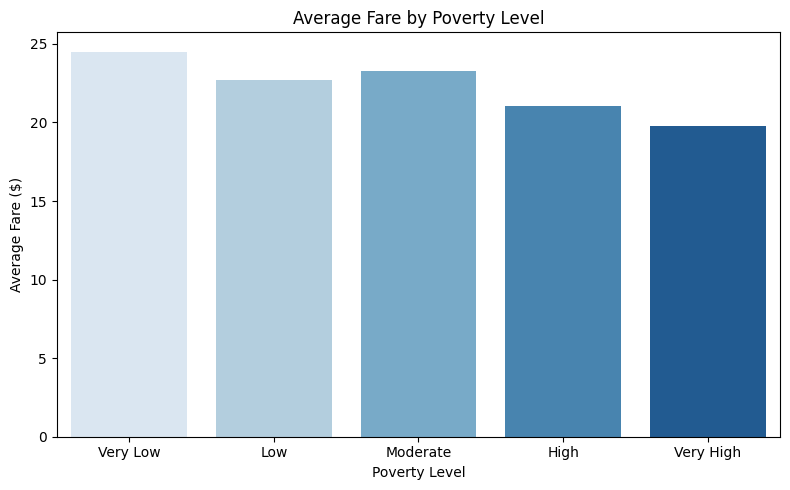

In [94]:
# Group by poverty_bin
poverty_summary = df_demo.groupby('poverty_bin').agg(
    avg_fare=('base_passenger_fare', 'mean')
).reset_index()

# Plot: Fare by Poverty Bin
plt.figure(figsize=(8, 5))
sns.barplot(data=poverty_summary, x='poverty_bin', y='avg_fare', palette='Blues')
plt.title("Average Fare by Poverty Level")
plt.xlabel("Poverty Level")
plt.ylabel("Average Fare ($)")
plt.tight_layout()
plt.show()


C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\seaborn\axisgrid.py:854: Futur

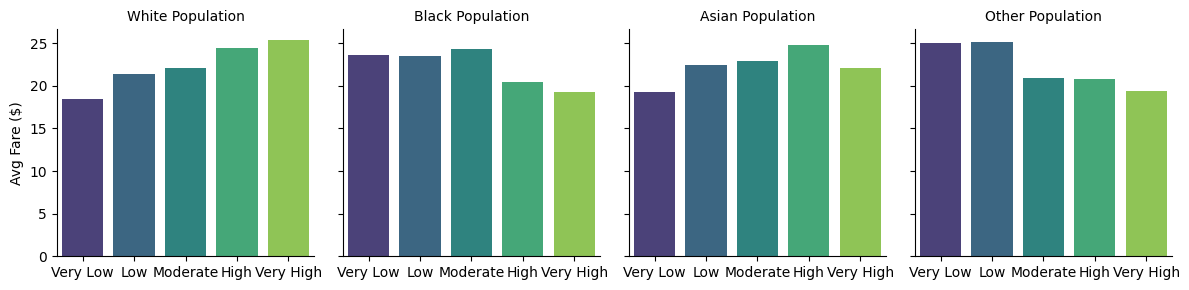

In [95]:
# Plot with FacetGrid
g = sns.FacetGrid(summary, col='Race', sharey=True, col_order=['White', 'Black', 'Asian', 'Other'])
g.map_dataframe(sns.barplot, x='RaceBin', y='avg_fare', palette='viridis')

# Tweak labels
g.set_axis_labels("", "Avg Fare ($)")  # <- This line removes the shared x-axis label
g.set_titles("{col_name} Population")

plt.tight_layout()
plt.show()


In [102]:
import geopandas as gpd

# Load NYC zip code shapefile or GeoJSON
nyc_zip_shapefile = gpd.read_file("nyc-zip-code-tabulation-areas-polygons.geojson")  # or .shp
nyc_zip_shapefile['dropoff_zipcode'] = nyc_zip_shapefile['postalCode'].astype(float)  # match dtype

# Merge with your demographic_summary
gdf = nyc_zip_shapefile.merge(demographic_summary, on='dropoff_zipcode', how='left')


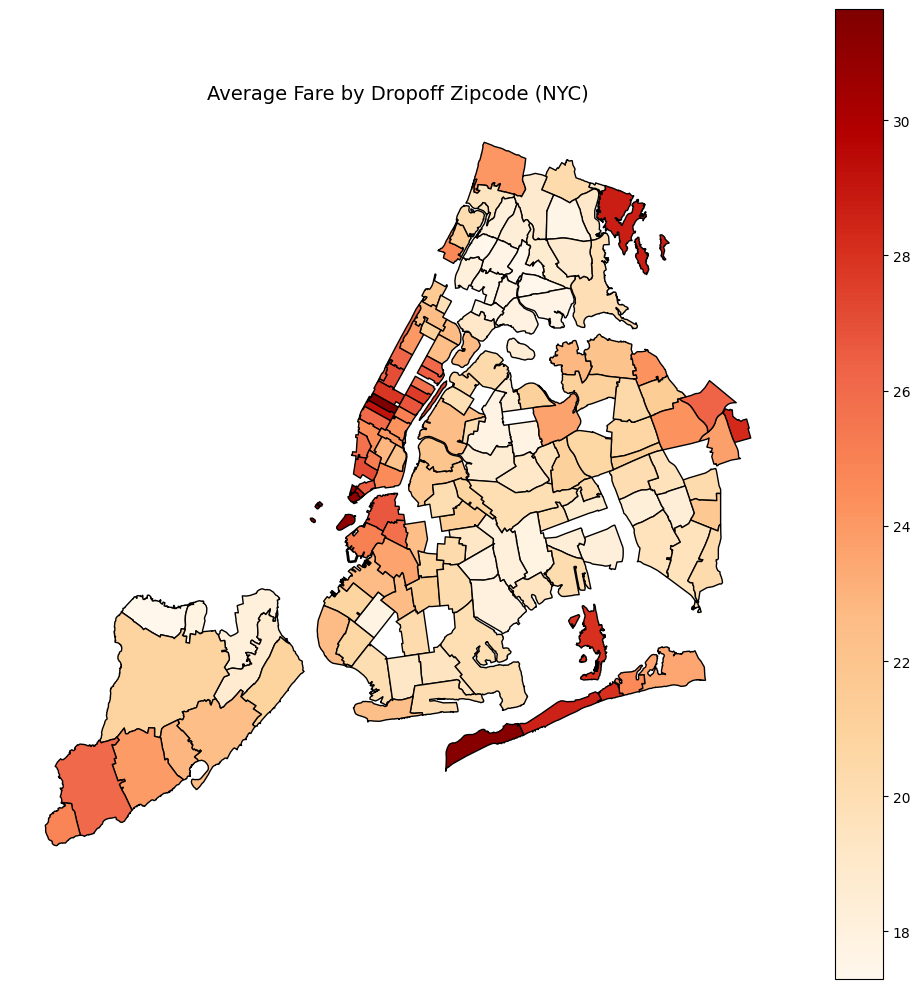

In [100]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='avg_fare', ax=ax, legend=True, cmap='OrRd', edgecolor='black')
ax.set_title("Average Fare by Dropoff Zipcode (NYC)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


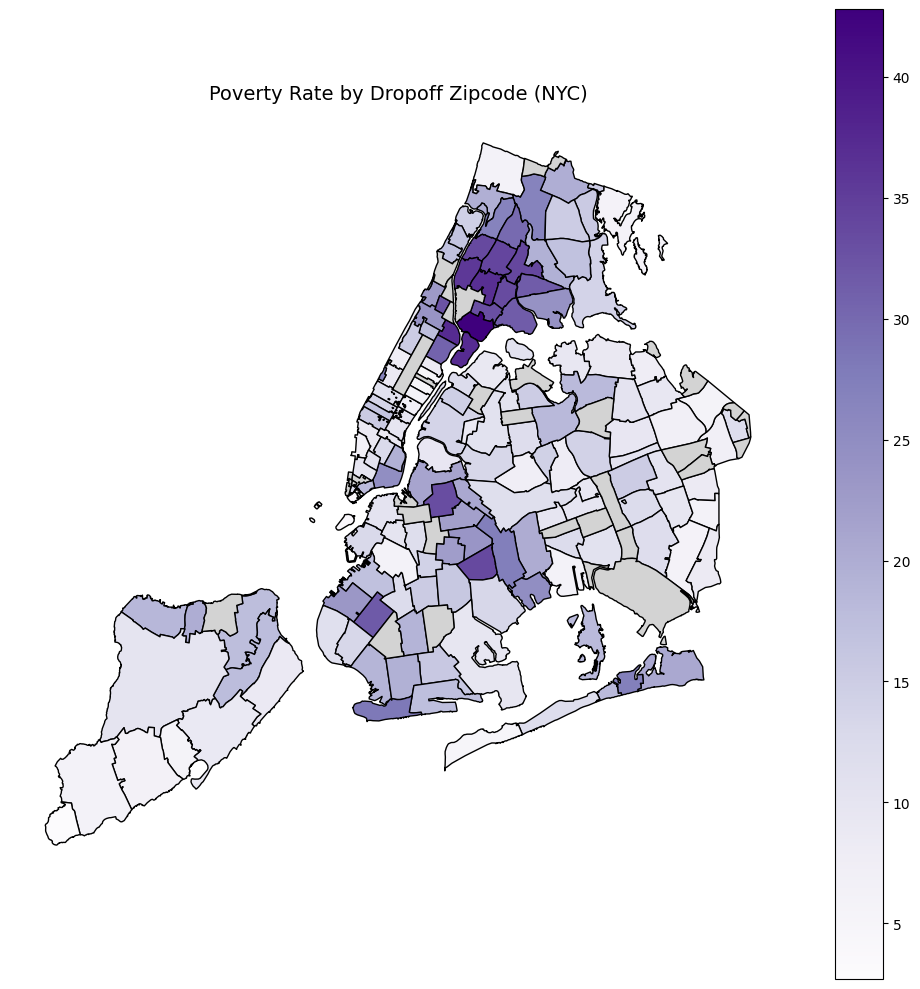

In [104]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    column='poverty_rate',
    ax=ax,
    legend=True,
    cmap='Purples',
    edgecolor='black',
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'}
)

ax.set_title("Poverty Rate by Dropoff Zipcode (NYC)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


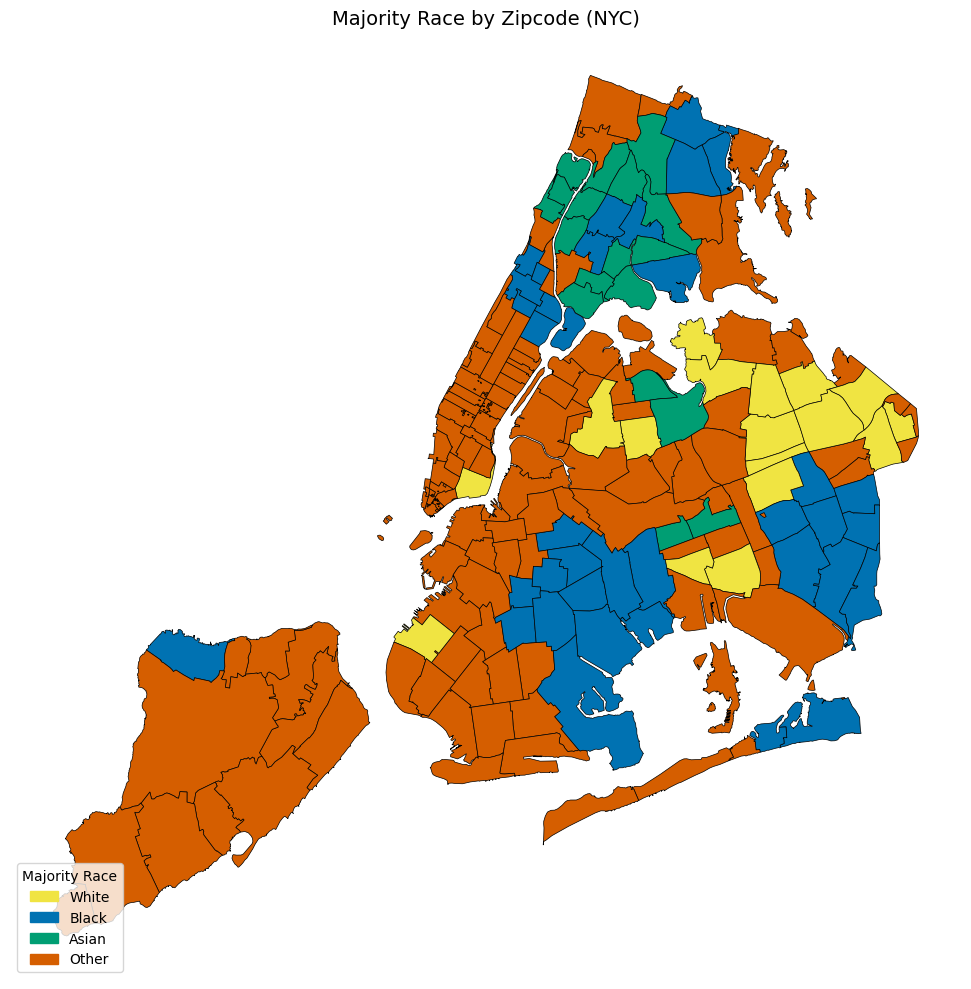

In [105]:
def get_majority_race(row):
    race_vals = {
        'White': row['white_pct'],
        'Black': row['black_pct'],
        'Asian': row['asian_pct'],
        'Other': row['other_pct']
    }
    return max(race_vals, key=race_vals.get)

gdf['majority_race'] = gdf.apply(get_majority_race, axis=1)

# Define a color map
race_colors = {
    'White': '#f0e442',
    'Black': '#0072b2',
    'Asian': '#009e73',
    'Other': '#d55e00'
}

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    column='majority_race',
    ax=ax,
    legend=True,
    cmap=plt.matplotlib.colors.ListedColormap([race_colors[r] for r in race_colors]),
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'}
)

# Create a custom legend
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=color, label=label) for label, color in race_colors.items()]
ax.legend(handles=handles, title="Majority Race", loc='lower left')

ax.set_title("Majority Race by Zipcode (NYC)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()